# **Project Background**
In this project we are going to predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The approach that we are going to use is using ARIMA (Auto Regressive Integrated moving Average) by examining past values to understand and predict points within a data sequence, which is particularly useful when dealing with data that change patterns or trends over time.

# **Data Preparation and Understanding**

## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import pearsonr

import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

## **Datasets**

In [2]:
# Load the dataset
train_df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv', parse_dates=['date'])
stores_df = pd.read_csv('stores.csv')
oil_df = pd.read_csv('oil.csv', parse_dates=['date'])
holidays_df = pd.read_csv('holidays_events.csv', parse_dates=['date'])

## **Data Understanding**

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [5]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [6]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [7]:
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


## **Dataset Merging**

In [8]:
holidays_df = holidays_df.rename(columns={'type': 'holiday_type'})

# Merge the datasets
train_df = train_df.merge(stores_df, on='store_nbr')
train_df = train_df.merge(oil_df, on='date', how='left')
train_df = train_df.merge(holidays_df, on='date', how='left')

In [9]:
# Check merged dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  holiday_type  object        
 12  locale        object        
 13  locale_name   object        
 14  description   object        
 15  transferred   object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(9)
memory usage: 372.8+ MB


In [10]:
# Handle missing values
train_df.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [11]:
missing_ptg = train_df.isnull().sum()/len(train_df)*100

missing_ptg

id               0.000000
date             0.000000
store_nbr        0.000000
family           0.000000
sales            0.000000
onpromotion      0.000000
city             0.000000
state            0.000000
type             0.000000
cluster          0.000000
dcoilwtico      31.271879
holiday_type    83.547258
locale          83.547258
locale_name     83.547258
description     83.547258
transferred     83.547258
dtype: float64

In [12]:
# Handle missing values
col_delete = missing_ptg[missing_ptg > 30].index
train_df = train_df.drop(columns=col_delete)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 233.0+ MB


In [14]:
# Check for duplicates
train_df.duplicated().sum()

53460

In [15]:
train_df = train_df.drop_duplicates()
train_df.duplicated().sum()

0

In [16]:
test_df.duplicated().sum()

0

# **EDA**

There are things that we need to explore in this dataset which includes:
1. Sales by store type
2. Sales by family type
3. Sales by promotion
4. Customers by city
5. Customers by state
6. Store that has the highest sales
7. Annual sales performance

But before that, we are going to see the summary statistics of the dataset, both the numeric and categorical variables.

In [17]:
train_df.describe()

,id,date,store_nbr,sales,onpromotion,cluster
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703087872,2.750000e+01,3.577757e+02,2.602770e+00,8.481481e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01,4.649735e+00


In [18]:
train_df.describe(include=['object', 'category'])

,family,city,state,type
count,3000888,3000888,3000888,3000888
unique,33,22,16,5
top,AUTOMOTIVE,Quito,Pichincha,D
freq,90936,1000296,1055868,1000296


## **Sales by Store Type**

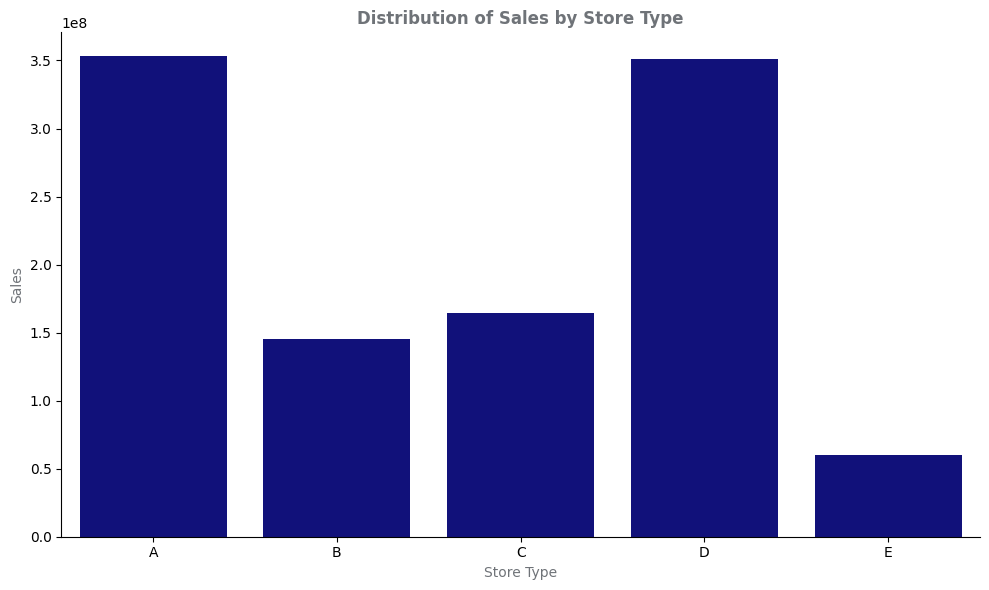

In [19]:
# Aggregate sales by store type and sort
sales_by_store = train_df.groupby('type')['sales'].sum().reset_index()
sales_by_store = sales_by_store.sort_values(by='type', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='type', y='sales', data=sales_by_store, color='darkblue')

sns.despine(right=True)

ax.set_xlabel('Store Type', color='#6F7378')
ax.set_ylabel('Sales', color='#6F7378')
ax.set_title('Distribution of Sales by Store Type', weight='bold', color='#6F7378')

plt.tight_layout()
plt.show()

It seems that based on the store type, the sales are not distributed normally. Therefore, we should test statistically using ANOVA. The goal is to tests whether there are significant differences in the means of sales across the different store types.

Before we can proceed, we need to formulate the hypotheses, which are:
1. H0: There is no significant difference in store sales between different types of store.
2. H1: There is significant difference in store sales between different types of store.

In [20]:
# Group sales by store type
sales_by_store = [train_df[train_df['type'] == store_type]['sales'].values for store_type in train_df['type'].unique() ]

# ANOVA
f_stat, p_value = stats.f_oneway(*sales_by_store)

print(f'ANOVA F-statistics: {f_stat}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

ANOVA F-statistics: 17766.023730362205
P-value: 0.0
Reject the null hypothesis


Based on the ANOVA F-statistics and P-value, we should reject the null hypothesis. Therefore, the type of stores does affect the sales as there is a significant difference in store sales between different type.

## **Sales by Family Type**
We should visualize the distribution of sales by the family types.

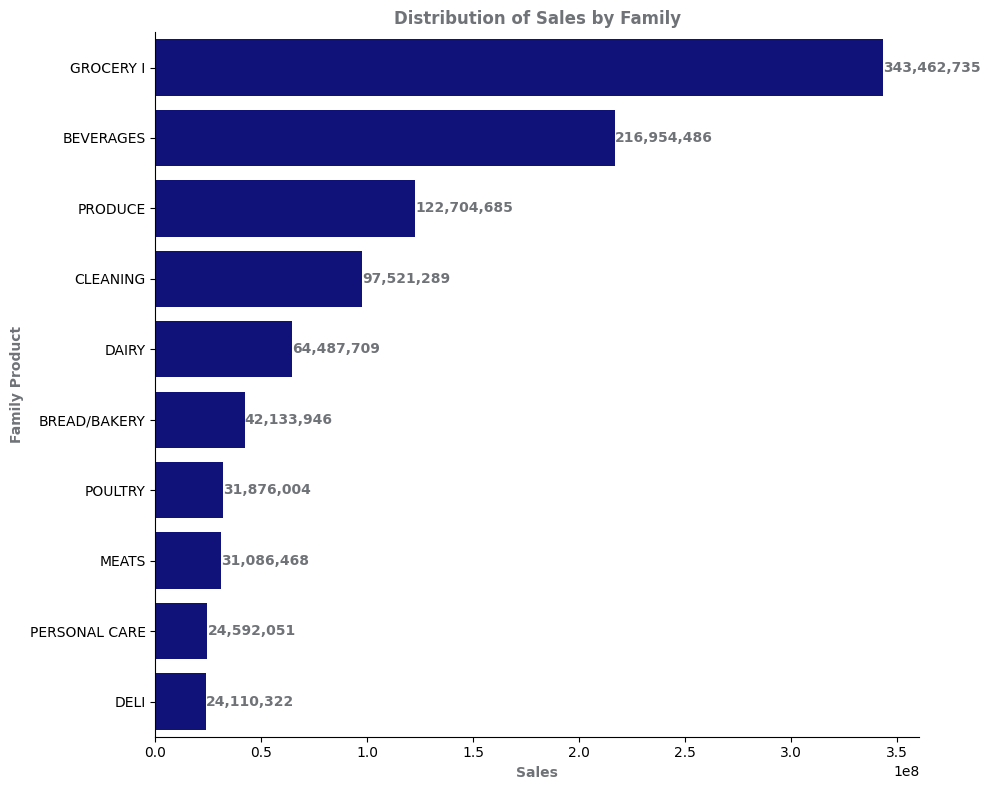

In [21]:
# Group sales data by family
sales_by_family = train_df.groupby('family')['sales'].sum().reset_index()
sales_by_family_sorted = sales_by_family.sort_values(by='sales', ascending=False)
top10_sales_by_family = sales_by_family_sorted.head(10)

# Visualize the distribution using bar plot
fig, ax = plt.subplots(figsize=(10,8))
barplot = sns.barplot(x='sales', y='family', data=top10_sales_by_family, color='darkblue')

sns.despine(right=True)

for index, value in enumerate(top10_sales_by_family['sales']):
    ax.text(value, index, f'{value:,.0f}', va='center', ha='left', color='#6F7378', fontweight='bold')

ax.set_xlabel('Sales', weight='bold', color='#6F7378')
ax.set_ylabel('Family Product', weight='bold', color='#6F7378')
ax.set_title('Distribution of Sales by Family', weight='bold', color='#6F7378')

plt.tight_layout()
plt.show()

Based on the plot above, we can conclude that GROCERY I, BEVERAGES, and PRODUCE is the top 3 family when sorted by the sales.

## **Sales by Promotion**
We should visualize and try to find the significant relationship between promotion and store sales.

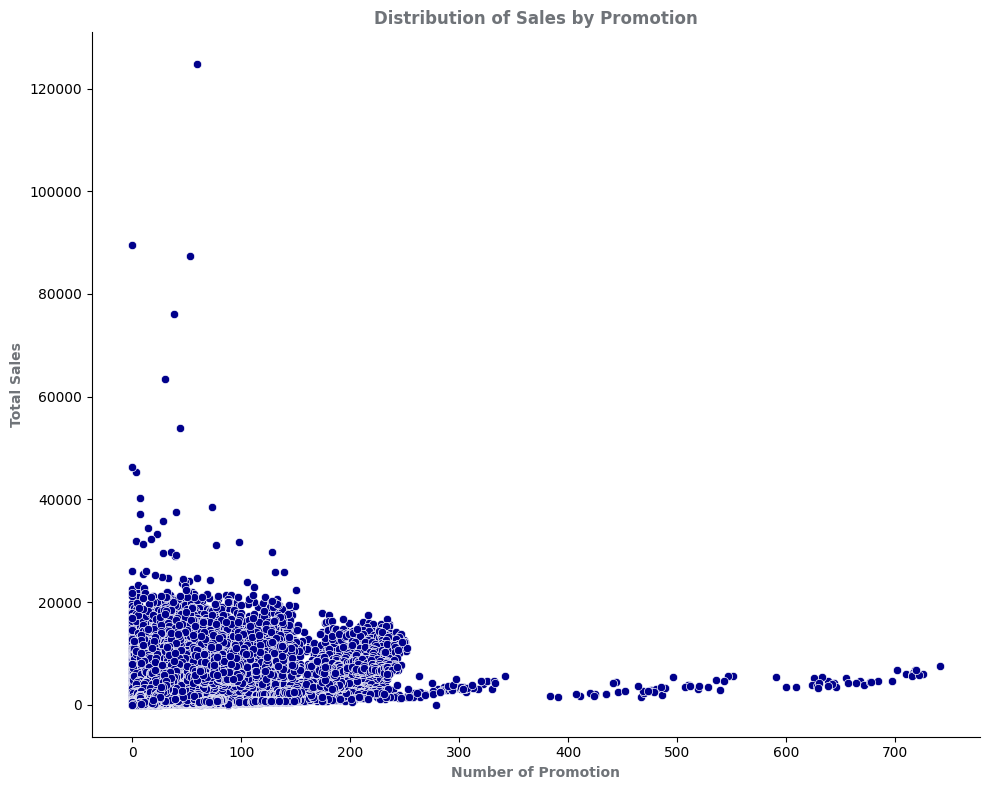

In [22]:
# Visualize the distribution using scatterplot
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='onpromotion', y='sales', data=train_df, color='darkblue')

sns.despine(right=True)

ax.set_xlabel('Number of Promotion', weight='bold', color='#6F7378')
ax.set_ylabel('Total Sales', weight='bold', color='#6F7378')
ax.set_title('Distribution of Sales by Promotion', weight='bold', color='#6F7378')

plt.tight_layout()
plt.show()

Since we cannot conclude anything from this graph, we are going to test it using Pearson Coefficient Correlation with these hypotheses:
1. H0 = The promotion does not affect store sales.
2. H1 = The promotion does affect store sales.

In [23]:
correlation, p_value = pearsonr(train_df['onpromotion'], train_df['sales'])

print('Pearson Correlation Coefficient: ', correlation)
print('P-value: ', p_value)

Pearson Correlation Coefficient:  0.42792320481344037
P-value:  0.0


Based on the Pearson Correlation Coefficient and P-value results of the test, we can say that we should reject the null hypothesis and conclude that there is a significant relationship between promotion and store sales. Therefore, the promotion does not affect store sales.

## **Customers by City**
We are going to visualize the customers by city to see the general distribution.

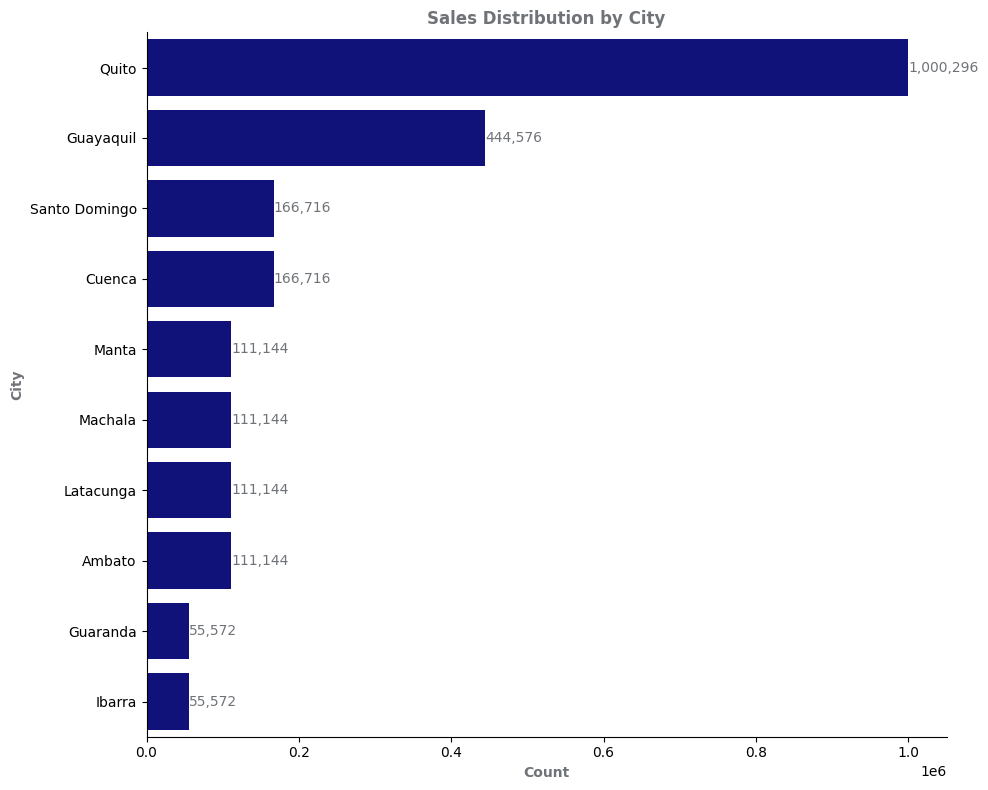

In [24]:
sales_by_city = train_df.groupby('city')['sales'].count().reset_index()
sales_by_city_sorted = sales_by_city.sort_values(by='sales', ascending=False)
top10_sales_by_city = sales_by_city_sorted.head(10)

# Visualize using bar plot
fig, ax = plt.subplots(figsize=(10,8))
barplot = sns.barplot(x='sales', y='city', data=top10_sales_by_city, color='darkblue')

sns.despine(right=True)

for index, value in enumerate(top10_sales_by_city['sales']):
    ax.text(value, index, f'{value:,.0f}', va='center', ha='left', color='#6F7378')

ax.set_xlabel('Count', weight='bold', color='#6F7378')
ax.set_ylabel('City', weight='bold', color='#6F7378')
ax.set_title('Sales Distribution by City', weight='bold', color='#6F7378')

plt.tight_layout()
plt.show()

Based on the visualization, we can conclude that **Quito** has the highest sales with over 1 million sales alone. Moreover, it is higher approximately 150% than the second highest city, which is **Guayaquil**.

## **Customers by State**
We are going to visualize the customers/sales by the state to identify trends that is unseen when trying to see the distribution of customers/sales by city.

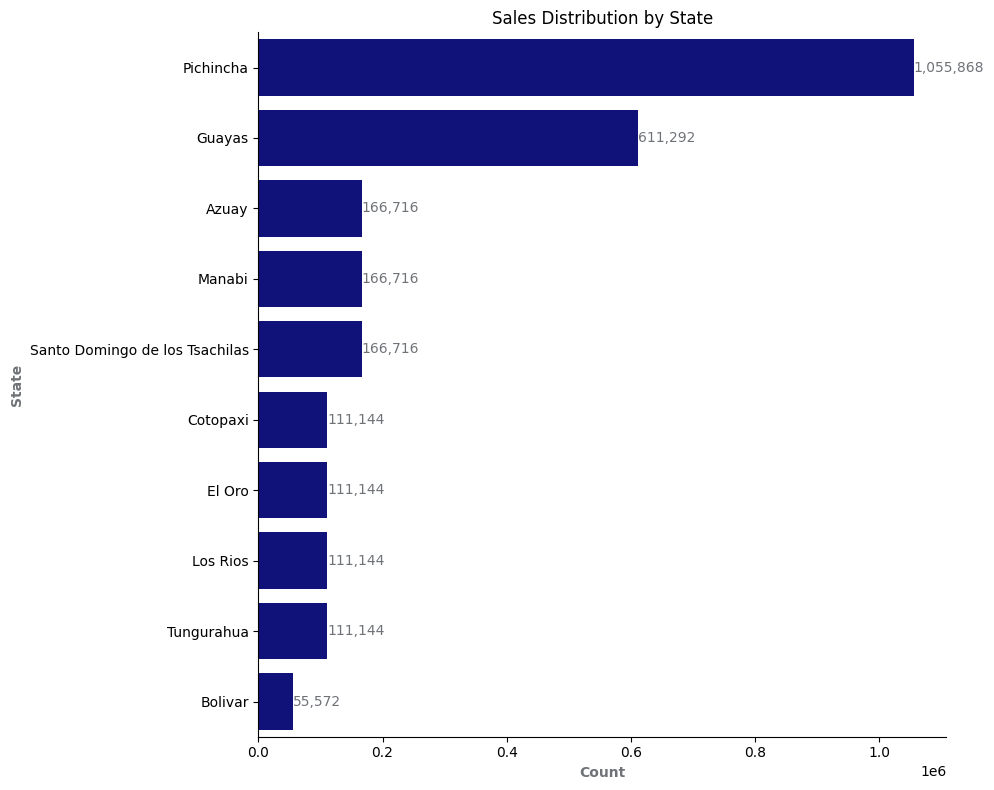

In [25]:
sales_by_state = train_df.groupby('state')['sales'].count().reset_index()
sales_by_state_sorted = sales_by_state.sort_values(by='sales', ascending=False)
top10_sales_by_state = sales_by_state_sorted.head(10)

# Visualize using bar plot
fig, ax = plt.subplots(figsize=(10,8))
barplot = sns.barplot(x='sales', y='state', data=top10_sales_by_state, color='darkblue')

sns.despine(right=True)

for index, value in enumerate(top10_sales_by_state['sales']):
    ax.text(value, index, f'{value:,.0f}', va='center', ha='left', color='#6F7378')

ax.set_xlabel('Count', weight='bold', color='#6F7378')
ax.set_ylabel('State', weight='bold', color='#6F7378')
ax.set_title('Sales Distribution by State')

plt.tight_layout()
plt.show()

Based on the visualization, we can see that **Pichinca** has the highest sales with a gap of approximately 80% with the second place, which is **Guayas**

## **Store with Highest Sales**
We should visualize the store that has the highest sales in a descending order.

In [30]:
# Group sales data by store
sales_by_store = train_df.groupby('store_nbr')['sales'].sum().reset_index()
sales_by_store_sorted = sales_by_store.sort_values(by='sales', ascending=False)
top10_sales_by_store = sales_by_store_sorted.head(10)

# Visualize using bar plot
fig, ax = plt.subplots(figsize=(10,8))
barplot = sns.barplot(x='sales', y='store_nbr', data=top10_sales_by_store, color='darkblue')

sns.despine(right=True)

for index, value in enumerate(top10_sales_by_store['sales']):
    ax.text(value, index, f'{value:,.0f}', va='center', ha='left', color='#6F7378')

ax.set_xlabel('Count', weight='bold', color='#6F7378')
ax.set_ylabel('Store', weight='bold', color='#6F7378')
ax.set_title('Sales Distribution by Store', weight='bold', color='#6F7378')

plt.show()

ValueError: Image size of 516818265x701 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x800 with 1 Axes>